In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pdb
import seaborn as sns
import warnings
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, TensorDataset,  random_split
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Load dataset
data = pd.read_csv('D:\\Excel data\\Saliva\\Healthy (Control)\\CONTROL DATASET.csv')

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [3]:
# PCA
pca = PCA(n_components=0.999)  
data_pca = pca.fit_transform(data_scaled)

In [4]:
# Convert the normalized data to a PyTorch tensor
data_tensor = torch.tensor(data_pca, dtype=torch.float32)

# Data dimensions (number of features)
input_dim = data_tensor.shape[1]

In [5]:
data.describe()

Wavelenght399  Wavelenght400  Wavelenght401  Wavelenght402  \
count     500.000000     500.000000     500.000000     500.000000   
mean        0.012250       0.012573       0.012779       0.012926   
std         0.015259       0.012853       0.011097       0.010596   
min        -0.014772       0.001000       0.001000       0.001000   
25%         0.001975       0.001600       0.003526       0.004287   
50%         0.007490       0.007041       0.009273       0.009949   
75%         0.021905       0.021530       0.019229       0.020147   
max         0.061457       0.057453       0.053860       0.048561   

       Wavelenght403  Wavelenght404  Wavelenght405  Wavelenght406  \
count     500.000000     500.000000     500.000000     500.000000   
mean        0.013061       0.013238       0.013531       0.014002   
std         0.010968       0.011433       0.011563       0.011362   
min         0.001000       0.001000       0.001000       0.001000   
25%         0.004016       0.003564       0.003591       0.004327   
50%         0.009853       0.009641       0.010528       0.011109   
75%         0.020276       0.020476       0.019827       0.020090   
max         0.044788       0.047300       0.049513       0.049830   

       Wavelenght407  Wavelenght408  ...  Wavelenght4125  Wavelenght4126  \
count     500.000000     500.000000  ...      500.000000      500.000000   
mean        0.014646       0.015350  ...        0.040388        0.040300   
std         0.011077       0.010877  ...        0.018788        0.018811   
min         0.001000       0.001000  ...        0.006680        0.006636   
25%         0.005191       0.006842  ...        0.025167        0.025067   
50%         0.011913       0.012970  ...        0.038208        0.038166   
75%         0.021587       0.022612  ...        0.054194        0.054263   
max         0.047316       0.047338  ...        0.094441        0.094415   

       Wavelenght4127  Wavelenght4128  Wavelenght4129  Wavelenght4130  \
count      500.000000      500.000000      500.000000      500.000000   
mean         0.040234        0.040180        0.040106        0.039998   
std          0.018828        0.018838        0.018845        0.018849   
min          0.006627        0.006655        0.006709        0.006764   
25%          0.025030        0.025106        0.025090        0.024775   
50%          0.037753        0.037555        0.037466        0.037299   
75%          0.054213        0.054108        0.054246        0.054207   
max          0.094062        0.093442        0.092693        0.092002   

       Wavelenght4131  Wavelenght4132  Wavelenght4133  Wavelenght4134  
count      500.000000      500.000000      500.000000      500.000000  
mean         0.039881        0.039802        0.039797        0.040209  
std          0.018849        0.018842        0.018833        0.018927  
min          0.006788        0.006755        0.006663        0.006622  
25%          0.024625        0.024532        0.024590        0.024983  
50%          0.037059        0.037192        0.037245        0.037873  
75%          0.054018        0.054151        0.054101        0.054605  
max          0.091551        0.091427        0.091561        0.092710  

[8 rows x 3736 columns]

In [6]:
# Wrap the tensor in a TensorDataset 
dataset = TensorDataset(data_tensor)

# Create a DataLoader
batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Example: iterate over batches
for batch in data_loader:
    inputs = batch[0]  
    print(inputs.shape)

torch.Size([64, 62])
torch.Size([64, 62])
torch.Size([64, 62])
torch.Size([64, 62])
torch.Size([64, 62])
torch.Size([64, 62])
torch.Size([64, 62])
torch.Size([52, 62])


In [7]:
# Wrap data tensor in a TensorDataset
dataset = TensorDataset(data_tensor)

# Define split ratio 
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for each split
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Example: Access batches
for batch in train_loader:
    inputs = batch[0]
    print(f"Train batch shape: {inputs.shape}")
    break

for batch in test_loader:
    inputs = batch[0]
    print(f"Test batch shape: {inputs.shape}")
    break

Train batch shape: torch.Size([64, 62])
Test batch shape: torch.Size([64, 62])


In [8]:
# Xavier initialization
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [9]:
noise_dim = 100
input_dim = 3736
epochs = 10000
batch_size = 64


# Generator network (improved)
class Generator(nn.Module):
    def __init__(self, noise_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, output_dim),
        )

    def forward(self, x):
        return self.model(x)

# Discriminator network (improved)
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [10]:
input_dim = data_tensor.shape[1]  
noise_dim = 100  

generator = Generator(noise_dim=noise_dim, output_dim=input_dim)
discriminator = Discriminator(input_dim=input_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=62, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [11]:
# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(noise_dim=noise_dim, output_dim=input_dim).to(device)
discriminator = Discriminator(input_dim=input_dim).to(device)


In [12]:
# Hyperparameters
noise_dim = 100
input_dim = 3736
epochs = 10000
batch_size = 64
lr_D = 0.0001
lr_G = 0.0002
beta1 = 0.5

adversarial_loss = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=300, gamma=0.95)
scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=300, gamma=0.95)

In [13]:
# Apply weight initialization
generator.apply(weights_init)
discriminator.apply(weights_init)

print("Models initialized & moved to:", device)

Models initialized & moved to: cpu


In [14]:
# Function to generate random noise for the generator
def generate_latent_points(batch_size, noise_dim, device):
    return torch.randn(batch_size, noise_dim, device=device)

Epoch [1000/10000] | D Loss: 0.6940 | G Loss: 0.6874
Generated images shape: (16, 62)
Epoch [2000/10000] | D Loss: 0.6832 | G Loss: 0.7212
Generated images shape: (16, 62)
Epoch [3000/10000] | D Loss: 0.6773 | G Loss: 0.7398
Generated images shape: (16, 62)
Epoch [4000/10000] | D Loss: 0.7169 | G Loss: 0.7178
Generated images shape: (16, 62)
Epoch [5000/10000] | D Loss: 0.6730 | G Loss: 0.7455
Generated images shape: (16, 62)
Epoch [6000/10000] | D Loss: 0.6305 | G Loss: 0.7925
Generated images shape: (16, 62)
Epoch [7000/10000] | D Loss: 0.6314 | G Loss: 0.7834
Generated images shape: (16, 62)
Epoch [8000/10000] | D Loss: 0.6071 | G Loss: 0.9391
Generated images shape: (16, 62)
Epoch [9000/10000] | D Loss: 0.6325 | G Loss: 0.8452
Generated images shape: (16, 62)
Epoch [10000/10000] | D Loss: 0.6892 | G Loss: 0.8204
Generated images shape: (16, 62)


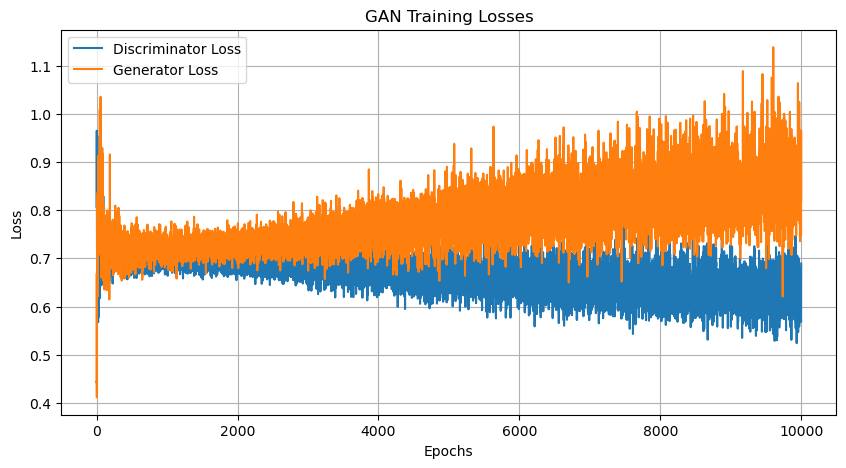

In [15]:
# Loss tracking
d_losses = []
g_losses = []

for epoch in range(epochs):
    generator.train()
    discriminator.train()

    for batch in train_loader:
        real_data = batch[0].to(device)
        batch_size_real = real_data.size(0)

        # Add Gaussian noise to real data
        noisy_real_data = real_data + 0.1 * torch.randn_like(real_data)

        # Labels with smoothing and noise
        real_labels = 0.9 + 0.1 * torch.rand((batch_size_real, 1), device=device)
        fake_labels = 0.05 * torch.rand((batch_size_real, 1), device=device)

        # --- Train Discriminator ---
        optimizer_D.zero_grad()

        z = generate_latent_points(batch_size_real, noise_dim, device)
        fake_data = generator(z)

        d_real = discriminator(noisy_real_data)
        d_fake = discriminator(fake_data.detach())

        d_loss_real = adversarial_loss(d_real, real_labels)
        d_loss_fake = adversarial_loss(d_fake, fake_labels)
        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()

        # --- Train Generator ---
        for _ in range(3):
            optimizer_G.zero_grad()
            z = generate_latent_points(batch_size_real, noise_dim, device)
            fake_data = generator(z)
            d_fake = discriminator(fake_data)
            g_loss = adversarial_loss(d_fake, real_labels)
            g_loss.backward()
            optimizer_G.step()

    scheduler_G.step()
    scheduler_D.step()

    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")
        with torch.no_grad():
            test_fake = generator(generate_latent_points(16, noise_dim, device)).cpu().numpy()
            print("Generated images shape:", test_fake.shape)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title("GAN Training Losses")
plt.show()

In [16]:
# Generate synthetic data

def generate_synthetic_data(generator, noise_dim, num_samples, device, pca=None, scaler=None):

    # Set generator to evaluation mode
    generator.eval()

    # Generate random noise (latent points)
    z = generate_latent_points(num_samples, noise_dim, device)

    # Generate synthetic data in PCA space
    with torch.no_grad():
        synthetic_pca_data = generator(z).cpu().numpy()

    # Inverse PCA transform (back to scaled feature space)
    if pca:
        synthetic_scaled = pca.inverse_transform(synthetic_pca_data)
    else:
        synthetic_scaled = synthetic_pca_data  

    # Inverse scaling (back to original feature space)
    if scaler:
        synthetic_final = scaler.inverse_transform(synthetic_scaled)
    else:
        synthetic_final = synthetic_scaled

    return synthetic_final


# === Example Usage ===

# Number of synthetic samples to generate
num_samples = 500

# Generate synthetic data
synthetic_data = generate_synthetic_data(
    generator=generator,
    noise_dim=noise_dim,
    num_samples=num_samples,
    device=device,
    pca=pca,       
    scaler=scaler  
)

# Convert to DataFrame
synthetic_df = pd.DataFrame(synthetic_data, columns=data.columns if 'data' in globals() else None)

# Display result
print(synthetic_df.head())

   Wavelenght399  Wavelenght400  Wavelenght401  Wavelenght402  Wavelenght403  \
0       0.000864       0.003785       0.005082       0.005450       0.005558   
1      -0.003051      -0.002392       0.002095       0.007291       0.010780   
2       0.014208       0.011921       0.009340       0.006779       0.004611   
3       0.001827       0.006219       0.012845       0.019259       0.024280   
4       0.023023       0.021226       0.016522       0.011065       0.006723   

   Wavelenght404  Wavelenght405  Wavelenght406  Wavelenght407  Wavelenght408  \
0       0.005787       0.006220       0.006761       0.007307       0.007827   
1       0.011825       0.011365       0.011348       0.013312       0.017052   
2       0.003264       0.003182       0.004585       0.007147       0.009945   
3       0.027471       0.028841       0.028658       0.027223       0.024652   
4       0.004654       0.005095       0.007377       0.010383       0.013229   

   ...  Wavelenght4125  Wavelenght4126

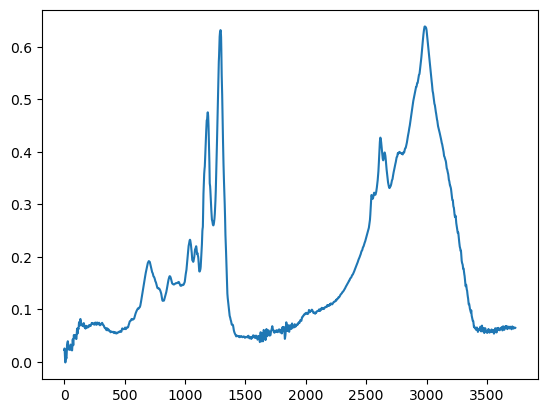

In [17]:
plt.plot(synthetic_data [10,:])

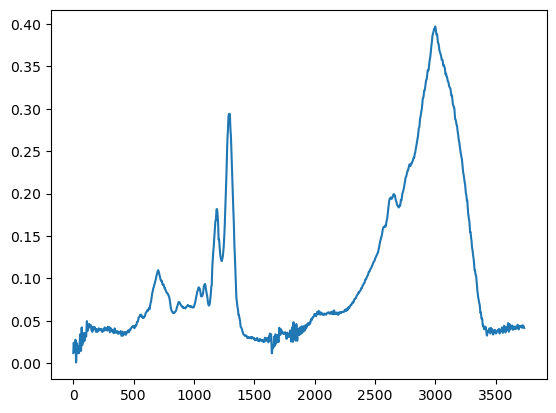

In [18]:
data = np.array(data) 
plt.plot(data[10, :]) 

In [19]:
# Save to CSV
synthetic_df.to_csv('synthetic_data_KNN.csv', index=False)

In [20]:
synthetic_data = pd.read_csv('C:\\Users\\Ahmed\\Final\\synthetic_data_KNN.csv') 

In [21]:
synthetic_data.describe()

Wavelenght399  Wavelenght400  Wavelenght401  Wavelenght402  \
count     500.000000     500.000000     500.000000     500.000000   
mean        0.009950       0.011379       0.012488       0.013122   
std         0.013796       0.012050       0.010700       0.010318   
min        -0.022443      -0.019071      -0.010203      -0.008318   
25%         0.000586       0.003099       0.005399       0.005822   
50%         0.007682       0.009164       0.010288       0.011219   
75%         0.016855       0.017081       0.017695       0.018958   
max         0.066147       0.062596       0.054798       0.052686   

       Wavelenght403  Wavelenght404  Wavelenght405  Wavelenght406  \
count     500.000000     500.000000     500.000000     500.000000   
mean        0.013291       0.013145       0.012946       0.012985   
std         0.010724       0.011295       0.011601       0.011562   
min        -0.009417      -0.011835      -0.014399      -0.015391   
25%         0.005553       0.005565       0.005486       0.005580   
50%         0.011533       0.010654       0.009963       0.010542   
75%         0.018895       0.018470       0.017393       0.017217   
max         0.048875       0.053614       0.057262       0.056580   

       Wavelenght407  Wavelenght408  ...  Wavelenght4125  Wavelenght4126  \
count     500.000000     500.000000  ...      500.000000      500.000000   
mean        0.013422       0.014153  ...        0.036952        0.036829   
std         0.011340       0.011082  ...        0.017784        0.017788   
min        -0.021045      -0.020421  ...        0.002273        0.001662   
25%         0.005958       0.006348  ...        0.023229        0.023004   
50%         0.011530       0.013133  ...        0.033998        0.033924   
75%         0.019133       0.020742  ...        0.047854        0.047826   
max         0.053938       0.050305  ...        0.092414        0.092184   

       Wavelenght4127  Wavelenght4128  Wavelenght4129  Wavelenght4130  \
count      500.000000      500.000000      500.000000      500.000000   
mean         0.036766        0.036744        0.036717        0.036651   
std          0.017771        0.017747        0.017729        0.017718   
min          0.001358        0.001399        0.001691        0.002076   
25%          0.023059        0.023092        0.022979        0.022909   
50%          0.033779        0.033593        0.033457        0.033274   
75%          0.047710        0.047403        0.047298        0.047143   
max          0.091727        0.091148        0.090600        0.090229   

       Wavelenght4131  Wavelenght4132  Wavelenght4133  Wavelenght4134  
count      500.000000      500.000000      500.000000      500.000000  
mean         0.036566        0.036512        0.036539        0.037035  
std          0.017711        0.017709        0.017720        0.017765  
min          0.002417        0.002647        0.002784        0.003424  
25%          0.023038        0.023154        0.023160        0.023529  
50%          0.033003        0.032859        0.033033        0.033672  
75%          0.047179        0.047134        0.047056        0.047320  
max          0.090131        0.090332        0.090793        0.091770  

[8 rows x 3736 columns]

In [22]:
Y = pd.read_csv("synthetic_data_KNN.csv")  

In [23]:
print (Y)

     Wavelenght399  Wavelenght400  Wavelenght401  Wavelenght402  \
0         0.000864       0.003785       0.005082       0.005450   
1        -0.003051      -0.002392       0.002095       0.007291   
2         0.014208       0.011921       0.009340       0.006779   
3         0.001827       0.006219       0.012845       0.019259   
4         0.023023       0.021226       0.016522       0.011065   
..             ...            ...            ...            ...   
495       0.005393       0.010429       0.013309       0.014476   
496       0.007530       0.008438       0.008552       0.007902   
497       0.003744       0.001736       0.000776       0.000564   
498       0.018521       0.014569       0.010736       0.008282   
499       0.033239       0.020756       0.010294       0.004367   

     Wavelenght403  Wavelenght404  Wavelenght405  Wavelenght406  \
0         0.005558       0.005787       0.006220       0.006761   
1         0.010780       0.011825       0.011365       0.0113

In [24]:
data_fake = Y

In [25]:
pip install --upgrade table_evaluator

Note: you may need to restart the kernel to use updated packages.


In [26]:
from table_evaluator import load_data, TableEvaluator

In [27]:
real, fake = load_data('D:\\Excel data\\Saliva\\Healthy (Control)\\CONTROL DATASET.csv', 'C:\\Users\\Ahmed\\Final\\synthetic_data_KNN.csv')

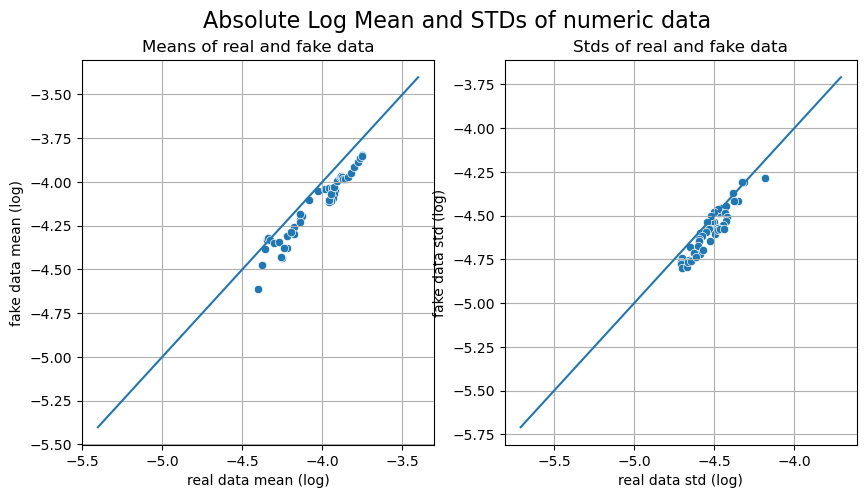

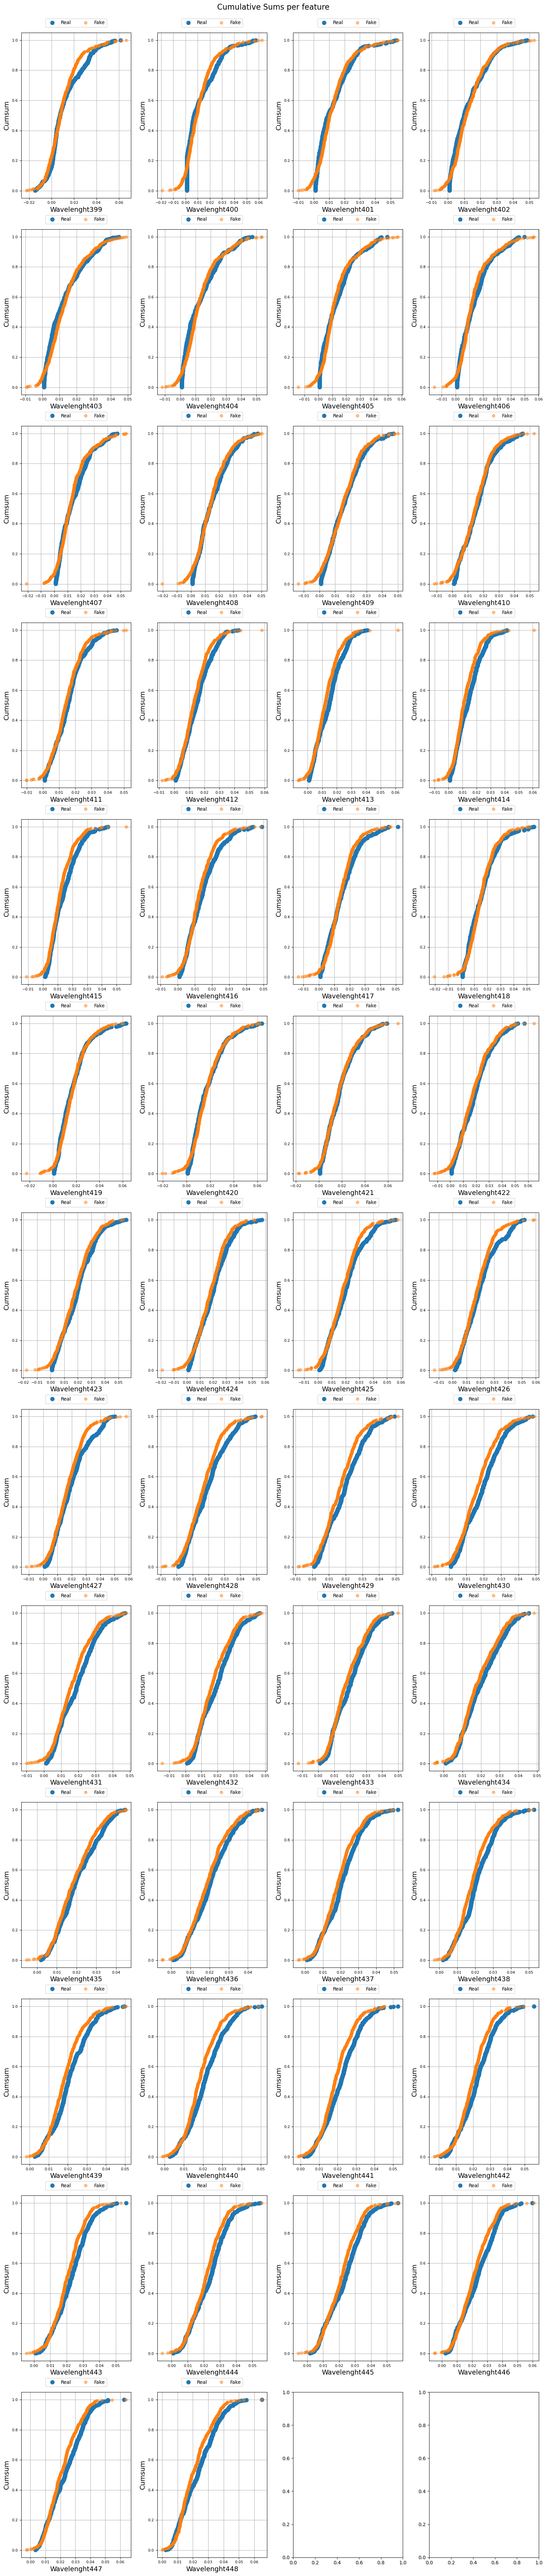

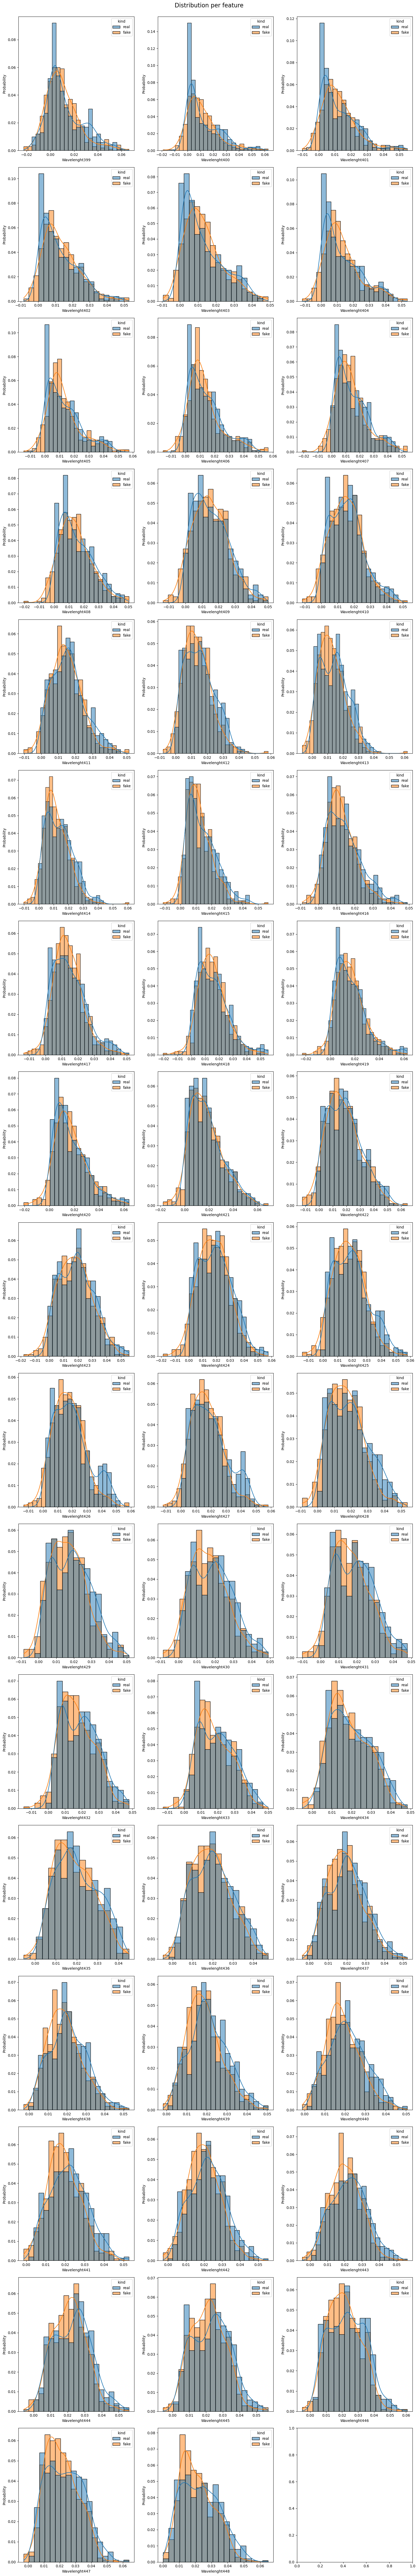

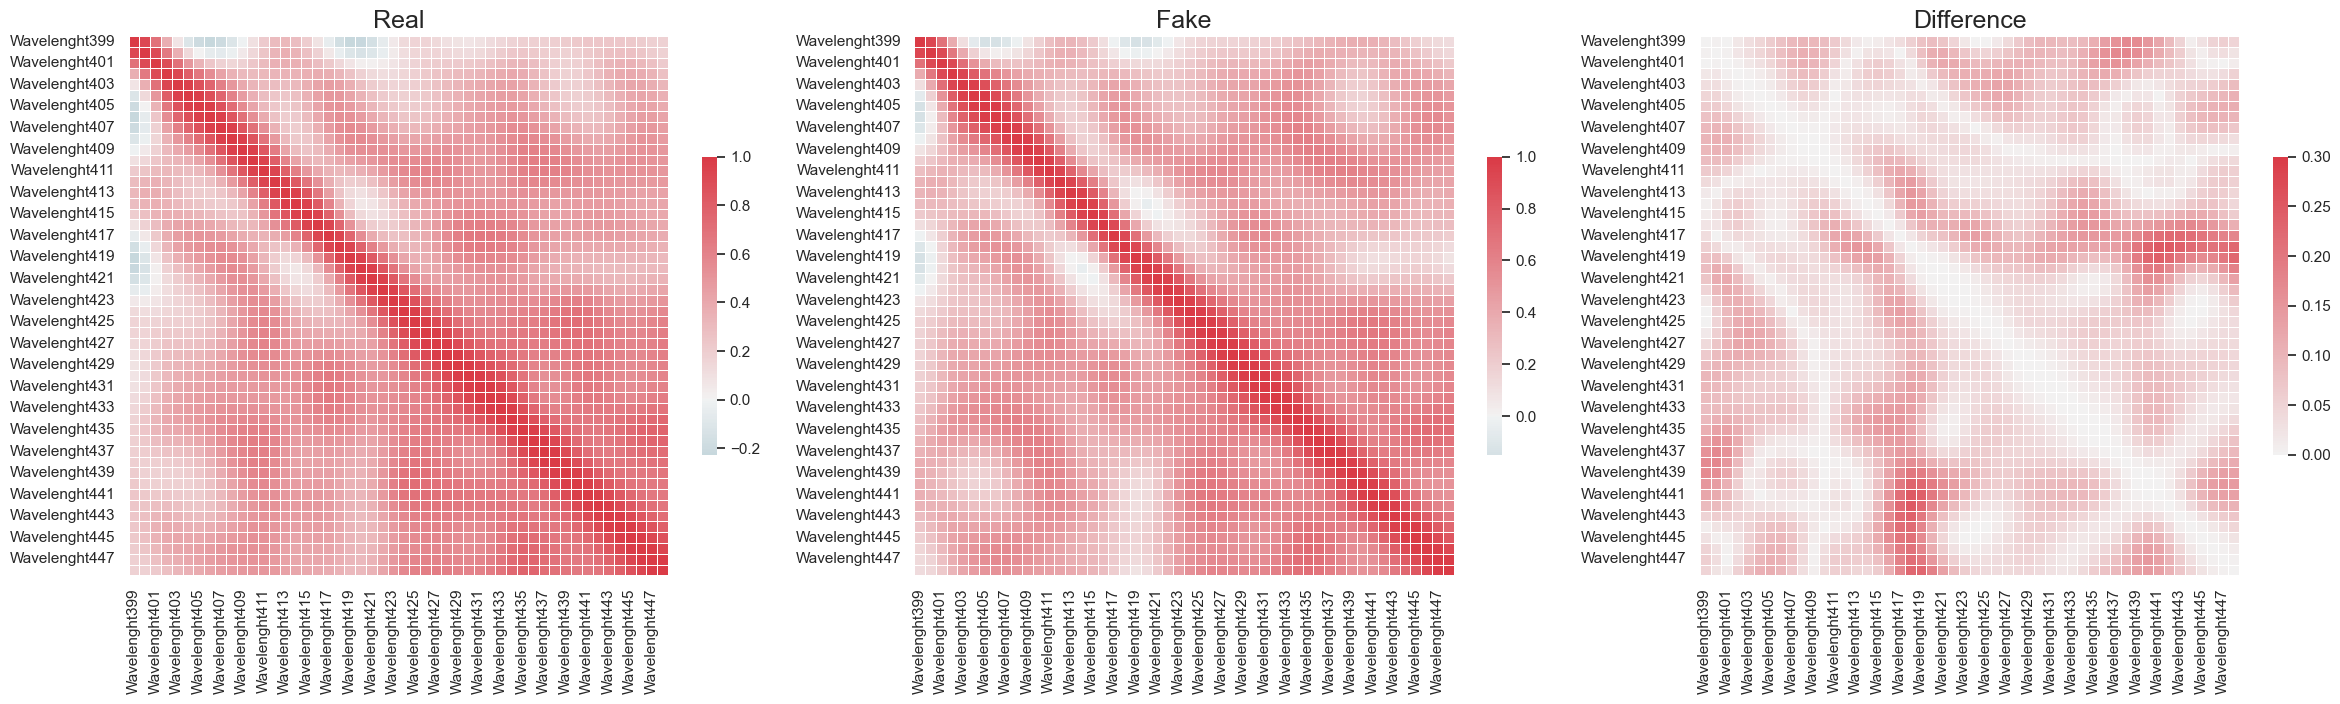

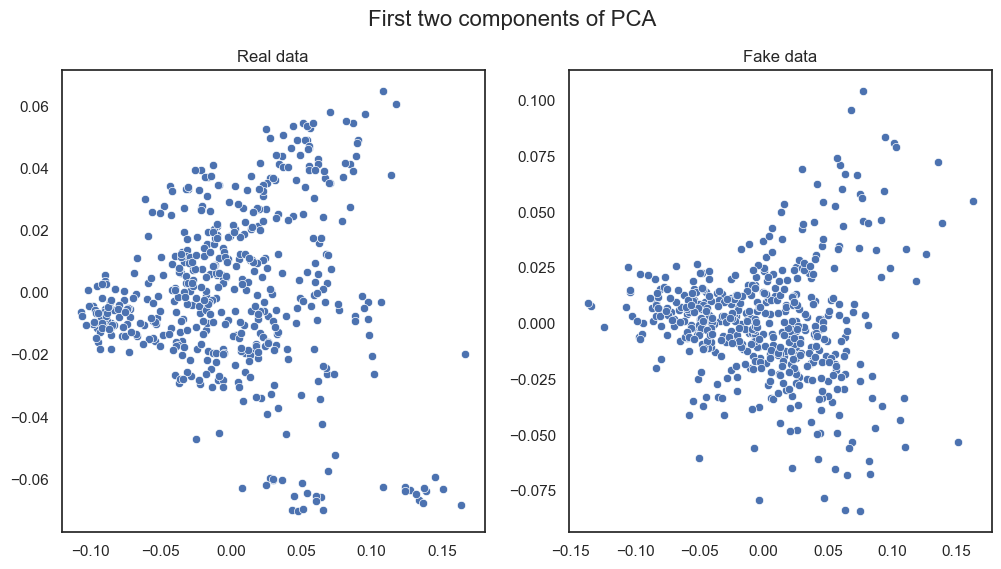

In [28]:
# Load your data into pandas DataFrames
real_data = pd.read_csv('D:\\Excel data\\Saliva\\Healthy (Control)\\CONTROL DATASET.csv')
fake_data = pd.read_csv('C:\\Users\\Ahmed\\Final\\synthetic_data_KNN.csv')

# Now you can proceed with your code
real = real_data
fake = fake_data

selected_columns = real_data.columns[:50]  
real_subset = real_data[selected_columns]
fake_subset = fake_data[selected_columns]

table_evaluator = TableEvaluator(real_subset, fake_subset)
table_evaluator.visual_evaluation()


In [29]:
# Apply the classifier

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# === Label datasets ===
real['label'] = 0  # Real
fake['label'] = 1  # Synthetic

# === Combine datasets ===
combined_data = pd.concat([real, fake], ignore_index=True)

# === Shuffle the data ===
combined_data = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)

# === Split features and labels ===
X = combined_data.drop('label', axis=1)
y = combined_data['label']

# === Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
# === Set up KNN Classifier ===
clf = KNeighborsClassifier(n_neighbors=10)  
clf.fit(X_train, y_train)

# === Predict ===
y_pred = clf.predict(X_test)

# === Evaluation ===
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

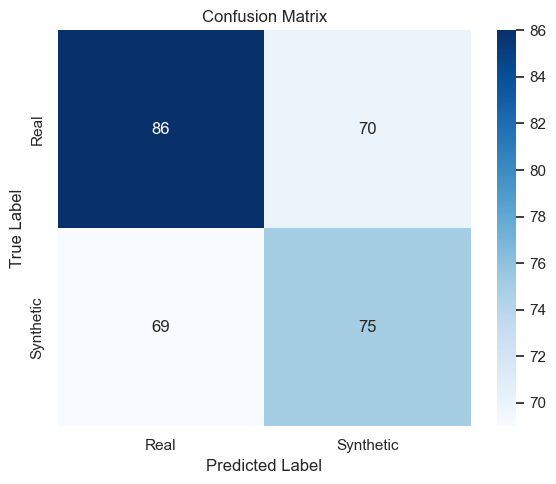

Accuracy:  0.54
Precision: 0.52
Recall:    0.52
F1 Score:  0.52


In [31]:
# === Display Confusion Matrix ===
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Synthetic"],
            yticklabels=["Real", "Synthetic"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix")
plt.tight_layout()
plt.show()

# === Print Metrics ===
print(f"Accuracy:  {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")

In [32]:
# 10-fold cross validation

# === Label datasets ===
real['label'] = 0  # Real
fake['label'] = 1  # Synthetic

# === Combine datasets ===
combined_data = pd.concat([real, fake], ignore_index=True)
combined_data = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)

# === Split features and labels ===
X = combined_data.drop('label', axis=1)
y = combined_data['label']

# === Set up KNN Classifier and Cross-Validation ===
clf = KNeighborsClassifier(n_neighbors=5)  
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === Cross-validated predictions ===
y_pred = cross_val_predict(clf, X, y, cv=cv)

Accuracy:  0.5810
Precision: 0.5757
Recall:    0.6160
F1 Score:  0.5952


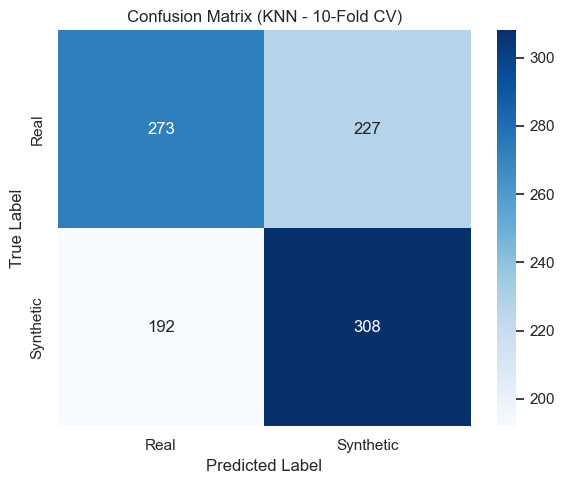

In [33]:
# === Compute metrics ===
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
conf_matrix = confusion_matrix(y, y_pred)

# === Print metrics ===
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# === Plot Confusion Matrix ===
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Real", "Synthetic"],
            yticklabels=["Real", "Synthetic"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (KNN - 10-Fold CV)')
plt.tight_layout()
plt.show()

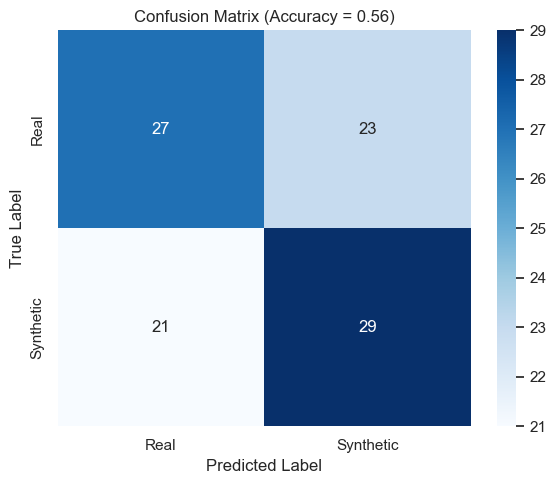

Accuracy:  0.5600
Precision: 0.5577
Recall:    0.5800
F1 Score:  0.5686


In [35]:
# Mixed the Real and the fake data, took 50% of each dataset, and combined them. 

# === Load datasets ===
real_data = pd.read_csv('D:\\Excel data\\Saliva\\Healthy (Control)\\CONTROL DATASET.csv')
fake_data = pd.read_csv('C:\\Users\\Ahmed\\Final\\synthetic_data_KNN.csv')

# === Take 50% from each dataset ===
real_sample = real_data.sample(frac=0.5, random_state=42)
fake_sample = fake_data.sample(frac=0.5, random_state=42)

# === Label the datasets ===
real_sample['label'] = 0  # Real
fake_sample['label'] = 1  # Synthetic

# === Combine datasets ===
combined_data = pd.concat([real_sample, fake_sample], ignore_index=True)
combined_data = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)

# === Split features and labels ===
X = combined_data.drop('label', axis=1)
y = combined_data['label']

# === Standardize features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# === Set up KNN Classifier ===
clf = KNeighborsClassifier(n_neighbors=10)  
clf.fit(X_train, y_train)

# === Predict ===
y_pred = clf.predict(X_test)

# === Evaluation ===
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# === Display Confusion Matrix ===
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Synthetic"],
            yticklabels=["Real", "Synthetic"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Accuracy = {accuracy:.2f})")
plt.tight_layout()
plt.show()

# === Print metrics ===
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")